In [2]:
import os
import sqlite3
from datetime import datetime
from tqdm import tqdm_notebook

import pandas as pd
import numpy as np
import geopandas as gpd

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px

from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

def f_requete_sql (requete) :
    try:
        connexion = sqlite3.connect('./data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

# Chargement des données de clustering piezo

In [3]:
 requete = """
        SELECT code_bss, latitude, longitude, altitude_station, profondeur_investigation, codes_bdlisa, cluster_kmeans, FRANCE_lvl_1, FRANCE_lvl_2, FRANCE_lvl_3, FRANCE_lvl_4, EtatEH, NatureEH, MilieuEH, ThemeEH, OrigineEH
        FROM data_piezo
        INNER JOIN TME
        ON codes_bdlisa = CodeEH
        WHERE cluster_kmeans IS NOT NULL
        """

data_piezo = pd.DataFrame(f_requete_sql(requete))
data_piezo.columns = ["code_bss", "latitude", "longitude", "altitude_station", "profondeur_investigation", "codes_bdlisa", "cluster_kmeans", "FRANCE_lvl_1", "FRANCE_lvl_2", "FRANCE_lvl_3", "FRANCE_lvl_4", "EtatEH", "NatureEH", "MilieuEH", "ThemeEH", "OrigineEH"]
data_piezo.set_index("code_bss", inplace=True)
data_piezo.head()

Connexion réussie à SQLite
Connexion SQLite est fermée


,latitude,longitude,altitude_station,profondeur_investigation,codes_bdlisa,cluster_kmeans,FRANCE_lvl_1,FRANCE_lvl_2,FRANCE_lvl_3,FRANCE_lvl_4,EtatEH,NatureEH,MilieuEH,ThemeEH,OrigineEH
code_bss,,,,,,,,,,,,,,,
03423X0056_100,48.190195,7.396716,174.0,10.7,221AA15,GES_C,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3121,2,5,1,1,1
06216X0228_P30-10,46.272865,3.401730,237.2,8.0,932AR01,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,2,5,1,1,1
09145X0057_N210,44.110203,4.751991,31.0,14.5,712IA01,PAC_A,FRANCE_3,FRANCE_31,FRANCE_313,FRANCE_3131,2,5,1,1,1
06932X0178_P10,45.892458,2.972177,801.8,48.0,153AA01,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,2,5,4,5,1
06505X0093_PZ10,46.128984,4.761390,175.0,19.0,507AD00,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,2,7,1,2,3


In [4]:
dict_etat = {"1":"Entité hydrogéologique à nappe captive" , 
             "2":"Entité hydrogéologique à nappe libre", 
             "3": "Entité hydrogéologique à parties libres et captives", 
             "4":"Entité hydrogéologique alternativement libre puis captive"}
dict_nature = {"0":"inconnue",
               "3":"Système aquifère", 
               "5":"Unité aquifère", 
               "6":"Unité semi-perméable",
               "7":"Unité imperméable"}
dict_milieu = {"1":"Poreux", 
               "2":"Sédimentaire", 
               "3": "Karstique", 
               "4":"Matricielle / fissures",
               "5": "Karstique / fissures",
               "6": "Fractures et/ou fissures",
               "8":"Matricielle / karstique",
               "9":"Matrice/fracture/karst"}
dict_theme = {"1":"Alluvial", 
              "2":"Sédimentaire", 
              "3":"Matricielle / fissures" , 
              "4":"Intensément plissés de montagne"}
dict_origine = {"1":"Carte géologique ou hydrogéologique", 
                "2":"Complétude Totale", 
                "3":"Complétude Partielle", 
                "4":"Agrégation par héritage"}

# Chargement de la carte lithologique

In [5]:
URL = 'http://mapsref.brgm.fr/wxs/infoterre/catalogue?SERVICE=WFS&REQUEST=GetFeature&VERSION=2.0.0&TYPENAMES=ms:LITHO_1M_SIMPLIFIEE'

litho = gpd.read_file(URL)

In [6]:
litho[["C_FOND", "M_FOND", "J_FOND", "N_FOND"]] = litho[["C_FOND", "M_FOND", "J_FOND", "N_FOND"]].astype(int, copy=False)

In [7]:
def cmyk_to_rgb(c, m, y, k, cmyk_scale, rgb_scale=1):
    r = rgb_scale * (1.0 - c / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    g = rgb_scale * (1.0 - m / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    b = rgb_scale * (1.0 - y / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    return r, g, b
litho["RGB"] = [tuple(color) for color in np.stack(cmyk_to_rgb(litho.C_FOND, litho.M_FOND, litho.J_FOND, litho.N_FOND, cmyk_scale = 100)).T]

In [8]:
litho.head()

,gml_id,OBJECTID,CODE_GEOL,SHAPE_Leng,SHAPE_Area,DESCR,TYPE,C_FOND,M_FOND,J_FOND,N_FOND,geometry,RGB
0,LITHO_1M_SIMPLIFIEE.535,535,8,3.04233668984e+003,5.59175016736e+005,Granites,Roches Magmatiques,0,100,100,0,"POLYGON ((9.25495 41.33883, 9.24708 41.34146, ...","(1.0, 0.0, 0.0)"
1,LITHO_1M_SIMPLIFIEE.536,536,8,5.17617655818e+003,1.30125962365e+006,Granites,Roches Magmatiques,0,100,100,0,"POLYGON ((9.26152 41.36311, 9.25263 41.36788, ...","(1.0, 0.0, 0.0)"
2,LITHO_1M_SIMPLIFIEE.537,537,8,3.10786133202e+004,3.40682284183e+007,Granites,Roches Magmatiques,0,100,100,0,"POLYGON ((9.22235 41.43062, 9.22585 41.42359, ...","(1.0, 0.0, 0.0)"
3,LITHO_1M_SIMPLIFIEE.538,538,6,17541.11331790000,10219135.3410000000,Sables,Roches Sédimentaires,0,0,55,0,"POLYGON ((8.95247 41.49212, 8.94354 41.48919, ...","(1.0, 1.0, 0.44999999999999996)"
4,LITHO_1M_SIMPLIFIEE.539,539,8,2.49423401374e+003,2.65434266465e+005,Granites,Roches Magmatiques,0,100,100,0,"POLYGON ((9.36211 41.54371, 9.35909 41.54462, ...","(1.0, 0.0, 0.0)"


<AxesSubplot:>

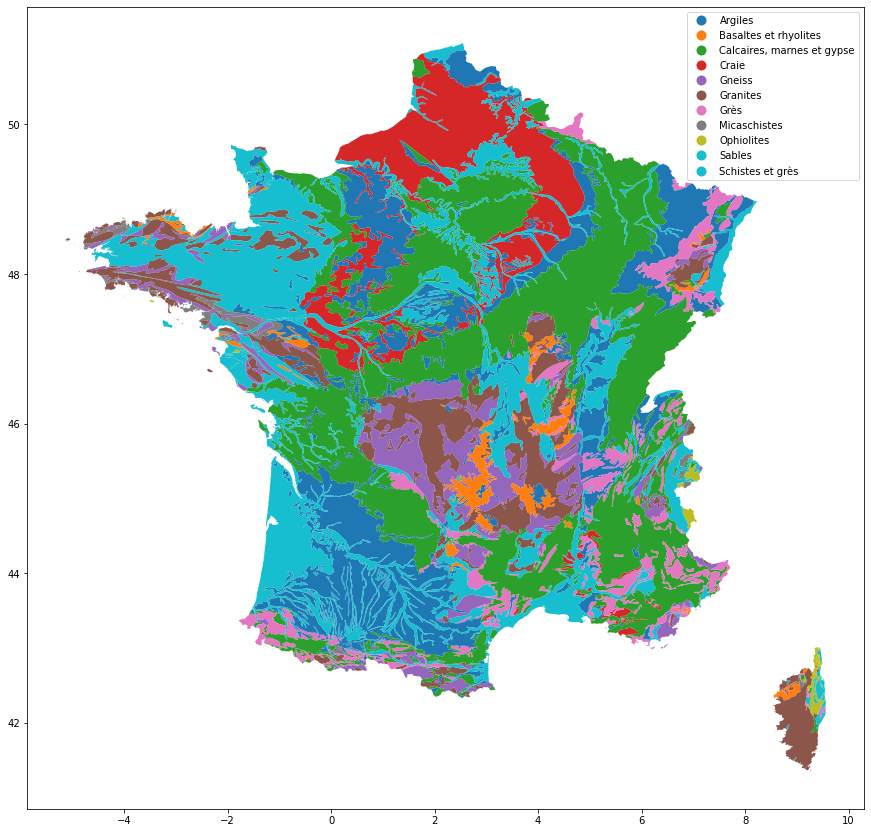

In [9]:
litho.plot(figsize=(15,15),
          column = "DESCR",
          legend = True)

# Jointure des dataframes

In [10]:
g_data_piezo = gpd.GeoDataFrame(
    data_piezo, geometry=gpd.points_from_xy(data_piezo.longitude, data_piezo.latitude, crs="CRS84"))
g_data_piezo.to_crs(crs='EPSG:4326', inplace=True)

data = gpd.sjoin(g_data_piezo, litho.loc[:,["DESCR", "TYPE", "geometry"]], how='left')
data.head()

,latitude,longitude,altitude_station,profondeur_investigation,codes_bdlisa,cluster_kmeans,FRANCE_lvl_1,FRANCE_lvl_2,FRANCE_lvl_3,FRANCE_lvl_4,EtatEH,NatureEH,MilieuEH,ThemeEH,OrigineEH,geometry,index_right,DESCR,TYPE
code_bss,,,,,,,,,,,,,,,,,,,
03423X0056_100,48.190195,7.396716,174.0,10.7,221AA15,GES_C,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3121,2,5,1,1,1,POINT (7.39672 48.19020),226.0,Argiles,Roches Sédimentaires
06216X0228_P30-10,46.272865,3.401730,237.2,8.0,932AR01,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,2,5,1,1,1,POINT (3.40173 46.27287),1341.0,Sables,Roches Sédimentaires
09145X0057_N210,44.110203,4.751991,31.0,14.5,712IA01,PAC_A,FRANCE_3,FRANCE_31,FRANCE_313,FRANCE_3131,2,5,1,1,1,POINT (4.75199 44.11020),1064.0,Sables,Roches Sédimentaires
06932X0178_P10,45.892458,2.972177,801.8,48.0,153AA01,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,2,5,4,5,1,POINT (2.97218 45.89246),470.0,Basaltes et rhyolites,Roches Magmatiques
06505X0093_PZ10,46.128984,4.761390,175.0,19.0,507AD00,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,2,7,1,2,3,POINT (4.76139 46.12898),402.0,Argiles,Roches Sédimentaires


In [11]:
liste_types = data.DESCR.unique()
liste_types

array(['Argiles', 'Sables', 'Basaltes et rhyolites', 'Grès',
       'Calcaires, marnes et gypse', 'Schistes et grès', 'Craie',
       'Granites', 'Gneiss', 'Micaschistes', 'Ophiolites', nan],
      dtype=object)

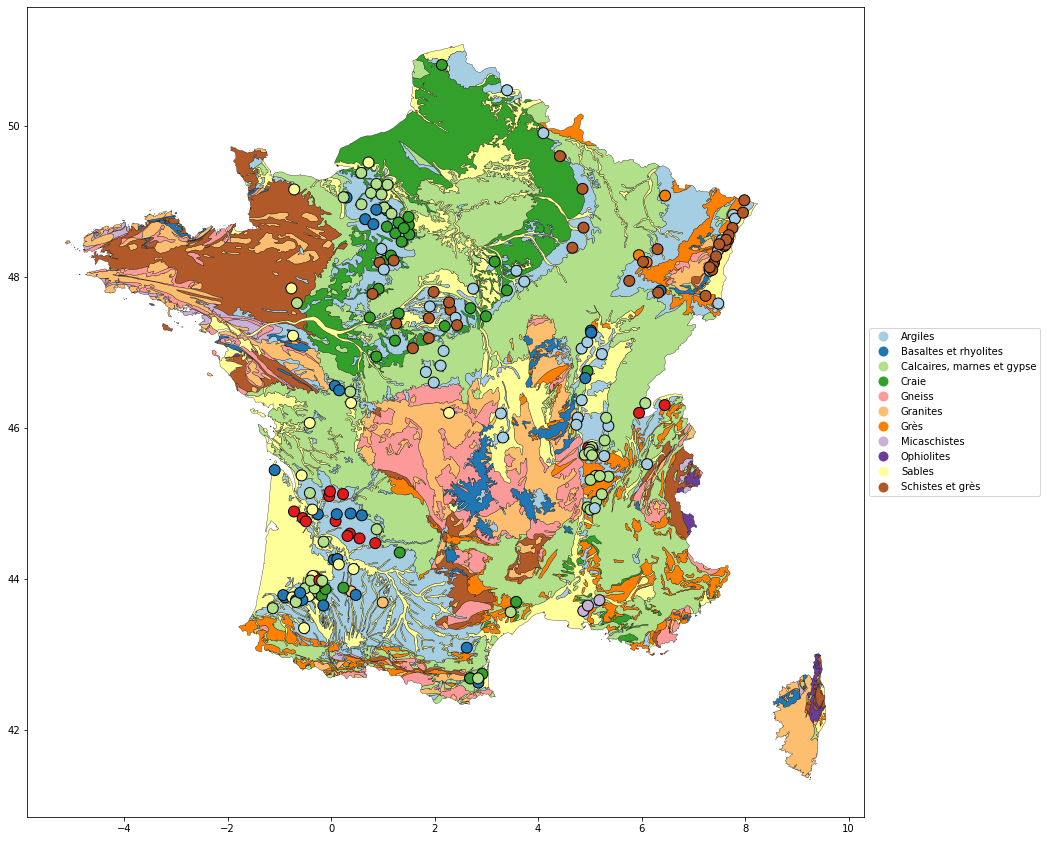

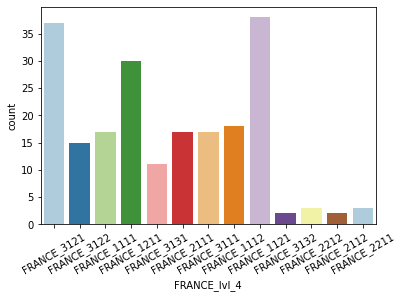

In [12]:
my_palette = sns.color_palette("Paired", n_colors=15)
my_cmap = ListedColormap(colors=my_palette)


fig, ax = plt.subplots(figsize=(15,15))

base = litho.plot(
            column = litho["DESCR"],
            ax = ax,  
            legend = True,
            linewidth=0.3,
            edgecolor='black',
            cmap = "Paired",
            legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})

type = 'Argiles'

clusters = data.loc[data["DESCR"] == type].plot(column="FRANCE_lvl_4",
            ax=ax, markersize=120, edgecolors="k", legend=False, cmap = my_cmap)

plt.show()

ax = sns.countplot(x= data.loc[data["DESCR"] == type, "FRANCE_lvl_4"], palette=my_palette)
_= ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

In [30]:
import plotly.graph_objs as go

In [34]:
fig = px.choropleth_mapbox(litho, geojson=litho.geometry, locations=litho.index, color="DESCR",
                           mapbox_style='open-street-map', opacity=0.5, labels={'DESCR': 'Type de sol'}, 
                           center={'lat': litho.geometry[1].centroid.y, 'lon': litho.geometry[1].centroid.x},
                           zoom=10)


fig.add_scattermapbox(
    data,
    lat = "latitude",
    lon = "longitude",
    text = "DESCR",
    marker_size=12,
    marker_color='rgb(235, 0, 100)'
)

fig.show()

ValueError: Invalid property specified for object of type plotly.graph_objs.Scattermapbox: 'color'

Did you mean "below"?

    Valid properties:
        below
            Determines if this scattermapbox trace's layers are to
            be inserted before the layer with the specified ID. By
            default, scattermapbox layers are inserted above all
            the base layers. To place the scattermapbox layers
            above every other layer, set `below` to "''".
        connectgaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the provided data arrays are connected.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            `customdata`.
        fill
            Sets the area to fill with a solid color. Use with
            `fillcolor` if not "none". "toself" connects the
            endpoints of the trace (or each segment of the trace if
            it has gaps) into a closed shape.
        fillcolor
            Sets the fill color. Defaults to a half-transparent
            variant of the line color, marker color, or marker line
            color, whichever is available.
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            `hoverinfo`.
        hoverlabel
            :class:`plotly.graph_objects.scattermapbox.Hoverlabel`
            instance or dict with compatible properties
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}" as well as %{xother}, {%_xother},
            {%_xother_}, {%xother_}. When showing info for several
            points, "xother" will be added to those with different
            x positions from the first point. An underscore before
            or after "(x|y)other" will add a space on that side,
            only when this field is shown. Numbers are formatted
            using d3-format's syntax %{variable:d3-format}, for
            example "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. The variables available in
            `hovertemplate` are the ones emitted as event data
            described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.  Anything contained in tag `<extra>` is
            displayed in the secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `hovertemplate`.
        hovertext
            Sets hover text elements associated with each (lon,lat)
            pair If a single string, the same string appears over
            all the data points. If an array of string, the items
            are mapped in order to the this trace's (lon,lat)
            coordinates. To be seen, trace `hoverinfo` must contain
            a "text" flag.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            `hovertext`.
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            `ids`.
        lat
            Sets the latitude coordinates (in degrees North).
        latsrc
            Sets the source reference on Chart Studio Cloud for
            `lat`.
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        legendgrouptitle
            :class:`plotly.graph_objects.scattermapbox.Legendgroupt
            itle` instance or dict with compatible properties
        legendrank
            Sets the legend rank for this trace. Items and groups
            with smaller ranks are presented on top/left side while
            with `*reversed* `legend.traceorder` they are on
            bottom/right side. The default legendrank is 1000, so
            that you can use ranks less than 1000 to place certain
            items before all unranked items, and ranks greater than
            1000 to go after all unranked items.
        line
            :class:`plotly.graph_objects.scattermapbox.Line`
            instance or dict with compatible properties
        lon
            Sets the longitude coordinates (in degrees East).
        lonsrc
            Sets the source reference on Chart Studio Cloud for
            `lon`.
        marker
            :class:`plotly.graph_objects.scattermapbox.Marker`
            instance or dict with compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        mode
            Determines the drawing mode for this scatter trace. If
            the provided `mode` includes "text" then the `text`
            elements appear at the coordinates. Otherwise, the
            `text` elements appear on hover.
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        opacity
            Sets the opacity of the trace.
        selected
            :class:`plotly.graph_objects.scattermapbox.Selected`
            instance or dict with compatible properties
        selectedpoints
            Array containing integer indices of selected points.
            Has an effect only for traces that support selections.
            Note that an empty array means an empty selection where
            the `unselected` are turned on for all points, whereas,
            any other non-array values means no selection all where
            the `selected` and `unselected` styles have no effect.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        stream
            :class:`plotly.graph_objects.scattermapbox.Stream`
            instance or dict with compatible properties
        subplot
            Sets a reference between this trace's data coordinates
            and a mapbox subplot. If "mapbox" (the default value),
            the data refer to `layout.mapbox`. If "mapbox2", the
            data refer to `layout.mapbox2`, and so on.
        text
            Sets text elements associated with each (lon,lat) pair
            If a single string, the same string appears over all
            the data points. If an array of string, the items are
            mapped in order to the this trace's (lon,lat)
            coordinates. If trace `hoverinfo` contains a "text"
            flag and "hovertext" is not set, these elements will be
            seen in the hover labels.
        textfont
            Sets the icon text font (color=mapbox.layer.paint.text-
            color, size=mapbox.layer.layout.text-size). Has an
            effect only when `type` is set to "symbol".
        textposition
            Sets the positions of the `text` elements with respects
            to the (x,y) coordinates.
        textsrc
            Sets the source reference on Chart Studio Cloud for
            `text`.
        texttemplate
            Template string used for rendering the information text
            that appear on points. Note that this will override
            `textinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. Every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available. variables `lat`, `lon` and `text`.
        texttemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `texttemplate`.
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        unselected
            :class:`plotly.graph_objects.scattermapbox.Unselected`
            instance or dict with compatible properties
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        
Did you mean "below"?

Bad property path:
color
^^^^^

In [19]:
data.head()

,latitude,longitude,altitude_station,profondeur_investigation,codes_bdlisa,cluster_kmeans,FRANCE_lvl_1,FRANCE_lvl_2,FRANCE_lvl_3,FRANCE_lvl_4,EtatEH,NatureEH,MilieuEH,ThemeEH,OrigineEH,geometry,index_right,DESCR,TYPE
code_bss,,,,,,,,,,,,,,,,,,,
03423X0056_100,48.190195,7.396716,174.0,10.7,221AA15,GES_C,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3121,2,5,1,1,1,POINT (7.39672 48.19020),226.0,Argiles,Roches Sédimentaires
06216X0228_P30-10,46.272865,3.401730,237.2,8.0,932AR01,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,2,5,1,1,1,POINT (3.40173 46.27287),1341.0,Sables,Roches Sédimentaires
09145X0057_N210,44.110203,4.751991,31.0,14.5,712IA01,PAC_A,FRANCE_3,FRANCE_31,FRANCE_313,FRANCE_3131,2,5,1,1,1,POINT (4.75199 44.11020),1064.0,Sables,Roches Sédimentaires
06932X0178_P10,45.892458,2.972177,801.8,48.0,153AA01,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,2,5,4,5,1,POINT (2.97218 45.89246),470.0,Basaltes et rhyolites,Roches Magmatiques
06505X0093_PZ10,46.128984,4.761390,175.0,19.0,507AD00,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,2,7,1,2,3,POINT (4.76139 46.12898),402.0,Argiles,Roches Sédimentaires


In [ ]:
import streamlit as st

selected_filter = st.selectbox("Choisir un filtre", ("Lithologie", "Clustering"))
st.write('You selected:', selected_filter)



In [ ]:
data.loc[data["DESCR"] == type, "FRANCE_lvl_4"]

In [ ]:
option = st.selectbox(
     'How would you like to be contacted?',
     ('Email', 'Home phone', 'Mobile phone'))

st.write('You selected:', option)

In [ ]:
x, y = "FRANCE_lvl_4", "DESCR"

data.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x, y='percent',hue=y,kind='bar')

In [ ]:
pd.crosstab(data.FRANCE_lvl_4, data.DESCR, margins=True, normalize="columns").round(2)*100

In [ ]:

data.groupby(by="cluster_kmeans")["DESCR"]
data.groupby(by="cluster_kmeans")["DESCR"].value_counts
data.groupby(by="cluster_kmeans")["DESCR"].value_counts()
pd.crosstab(data.FRANCE_lvl_2, data.DESCR)
pd.crosstab(data.FRANCE_lvl_2, data.DESCR, normalize="columns")
data.DESCR.value_counts
data.DESCR.value_counts()
pd.crosstab(data.FRANCE_lvl_2, data.DESCR, normalize="columns", margins="index")
pd.crosstab(data.FRANCE_lvl_2, data.DESCR, normalize="columns", margins=True)
data.cluster_kmeans.value_counts()
data.FRANCE_lvl_2.value_counts()
pd.crosstab(data.FRANCE_lvl_2, data.DESCR, normalize="index", margins=True)
pd.crosstab(data.FRANCE_lvl_2, data.DESCR, normalize="index")
pd.crosstab(data.FRANCE_lvl_2, data.DESCR, normalize="columns")
pd.crosstab(data.FRANCE_lvl_2, data.DESCR, normalize=True)
sns.heatmap(pd.crosstab(data.FRANCE_lvl_2, data.DESCR, normalize=True))
sns.heatmap(pd.crosstab(data.FRANCE_lvl_3, data.DESCR, normalize=True))
sns.heatmap(pd.crosstab(data.FRANCE_lvl_3, data.DESCR, normalize=index))
sns.heatmap(pd.crosstab(data.FRANCE_lvl_3, data.DESCR, normalize="index"))
sns.heatmap(pd.crosstab(data.FRANCE_lvl_3, data.DESCR)
sns.heatmap(pd.crosstab(data.FRANCE_lvl_3, data.DESCR))
pd.crosstab(data.FRANCE_lvl_3, data.DESCR)
pd.crosstab(data.FRANCE_lvl_3, data.DESCR, margins=True)





pd.crosstab(data.FRANCE_lvl_4, data.DESCR, margins=True)
pd.crosstab(data.FRANCE_lvl_4, data.DESCR, margins=True, normalize='index')
pd.crosstab(data.FRANCE_lvl_4, data.DESCR, margins=True, normalize='index').round(1)
pd.crosstab(data.FRANCE_lvl_4, data.DESCR, margins=True, normalize='index').round(2)
base = litho.plot(figsize=(15,15),
          column = litho["DESCR"],
           color = litho["RGB"],
          legend = True,
           linewidth=0.3,
            edgecolor='black')

data.plot(column="FRANCE_lvl_4",
            ax=base, marker='o', markersize=5)
base = litho.plot(figsize=(15,15),
          column = litho["DESCR"],
           color = litho["RGB"],
          legend = True,
           linewidth=0.3,
            edgecolor='black')

data.plot(column="FRANCE_lvl_4",
            ax=base, marker='o', markersize=20)
base = litho.plot(figsize=(15,15),
          column = litho["DESCR"],
           color = litho["RGB"],
          legend = True,
           linewidth=0.3,
            edgecolor='black')

data.plot(column="FRANCE_lvl_4",
            ax=base, marker='o', markersize=20, legendgend=True)
base = litho.plot(figsize=(15,15),
          column = litho["DESCR"],
           color = litho["RGB"],
          legend = True,
           linewidth=0.3,
            edgecolor='black')

data.plot(column="FRANCE_lvl_4",
            ax=base, marker='o', markersize=20, legend=True)
base = litho.plot(figsize=(15,15),
          column = litho["DESCR"],
           color = litho["RGB"],
          legend = True,
           linewidth=0.3,
            edgecolor='black')

data.plot(column="FRANCE_lvl_1",
            ax=base, marker='o', markersize=20, legend=True)
base = litho.plot(figsize=(15,15),
          column = litho["DESCR"],
           color = litho["RGB"],
          legend = True,
           linewidth=0.3,
            edgecolor='black')

data.plot(column="FRANCE_lvl_1",
            ax=base, marker='o', markersize=20, legend=True, cmap="viridis")
base = litho.plot(figsize=(15,15),
          column = litho["DESCR"],
           color = litho["RGB"],
          legend = True,
           linewidth=0.3,
            edgecolor='black')

data.plot(column="FRANCE_lvl_2",
            ax=base, marker='o', markersize=20, legend=True, cmap="viridis")
base = litho.plot(figsize=(15,15),
          column = litho["DESCR"],
           color = litho["RGB"],
          legend = True,
           linewidth=0.3,
            edgecolor='black')

data.plot(column="FRANCE_lvl_3",
            ax=base, marker='o', markersize=20, legend=True, cmap="viridis")
markers = {'.': 'point', ',': 'pixel', 'o': 'circle', 'v': 'triangle_down', '^': 'triangle_up', '<': 'triangle_left', '>': 'triangle_right', '1': 'tri_down', '2': 'tri_up', '3': 'tri_left', '4': 'tri_right', '8': 'octagon', 's': 'square', 'p': 'pentagon', '*': 'star', 'h': 'hexagon1', 'H': 'hexagon2', '+': 'plus', 'x': 'x', 'D': 'diamond', 'd': 'thin_diamond', '|': 'vline', '_': 'hline', 'P': 'plus_filled', 'X': 'x_filled', 0: 'tickleft', 1: 'tickright', 2: 'tickup', 3: 'tickdown', 4: 'caretleft', 5: 'caretright', 6: 'caretup', 7: 'caretdown', 8: 'caretleftbase', 9: 'caretrightbase', 10: 'caretupbase', 11: 'caretdownbase', 'None': 'nothing', None: 'nothing', ' ': 'nothing', '': 'nothing'}
base = litho.plot(figsize=(15,15),
          column = litho["DESCR"],
           color = litho["RGB"],
          legend = True,
           linewidth=0.3,
            edgecolor='black')

data.plot(column="FRANCE_lvl_3",
            ax=base, marker='o', markersize=20, legend=True, cmap="viridis", marker = markers)
base = litho.plot(figsize=(15,15),
          column = litho["DESCR"],
           color = litho["RGB"],
          legend = True,
           linewidth=0.3,
            edgecolor='black')

data.plot(column="FRANCE_lvl_3",
            ax=base, marker='o', markersize=20, legend=True, cmap="viridis", shape = markers)
base = litho.plot(figsize=(15,15),
          column = litho["DESCR"],
           color = litho["RGB"],
          legend = True,
           linewidth=0.3,
            edgecolor='black')

data.plot(column="FRANCE_lvl_3",
            ax=base, marker=markers, markersize=20, legend=True, cmap="viridis")
markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
base = litho.plot(figsize=(15,15),
          column = litho["DESCR"],
           color = litho["RGB"],
          legend = True,
           linewidth=0.3,
            edgecolor='black')

data.plot(column="FRANCE_lvl_3",
            ax=base, marker=markers, markersize=20, legend=True, cmap="viridis")
markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
base = litho.plot(figsize=(15,15),
          column = litho["DESCR"],
           color = litho["RGB"],
          legend = True,
           linewidth=0.3,
            edgecolor='black')

data.plot(column="FRANCE_lvl_3",
            ax=base, marker=markers, markersize=20, legend=True, cmap="viridis")
base = litho.plot(figsize=(15,15),
          column = litho["DESCR"],
           color = litho["RGB"],
          legend = True,
           linewidth=0.3,
            edgecolor='black')

data.plot(column="FRANCE_lvl_3",
            ax=base, markersize=20, legend=True, cmap="viridis")
base = litho.plot(figsize=(15,15),
          column = litho["DESCR"],
           color = litho["RGB"],
          legend = True,
           linewidth=0.3,
            edgecolor='black')

data.plot(column="FRANCE_lvl_3",
            ax=base, markersize=20, legend=True, cmap="hsv")
base = litho.plot(figsize=(15,15),
          column = litho["DESCR"],
           color = litho["RGB"],
          legend = True,
           linewidth=0.3,
            edgecolor='black')

data.plot(column="FRANCE_lvl_3",
            ax=base, markersize=20, legend=True, cmap="paired")
base = litho.plot(figsize=(15,15),
          column = litho["DESCR"],
           color = litho["RGB"],
          legend = True,
           linewidth=0.3,
            edgecolor='black')

data.plot(column="FRANCE_lvl_3",
            ax=base, markersize=20, legend=True, cmap="Paired")
data.columns()
data.columns
data[['cluster_kmeans', 'FRANCE_lvl_1', 'FRANCE_lvl_2',
       'FRANCE_lvl_3', 'FRANCE_lvl_4', 'NatureEH', 'MilieuEH',
       'ThemeEH', 'DESCR', 'TYPE']]
sns.pairplot(data[['cluster_kmeans', 'FRANCE_lvl_1', 'FRANCE_lvl_2',
       'FRANCE_lvl_3', 'FRANCE_lvl_4', 'NatureEH', 'MilieuEH',
       'ThemeEH', 'DESCR', 'TYPE']])
test = data[['cluster_kmeans', 'FRANCE_lvl_1', 'FRANCE_lvl_2',
       'FRANCE_lvl_3', 'FRANCE_lvl_4', 'NatureEH', 'MilieuEH',
       'ThemeEH', 'DESCR', 'TYPE']]
test
sns.pairplot(test)
test.head()
test.corr()

            
table = pd.crosstab(test.FRANCE_lvl_4, test.DESCR)
table
resultat_test = chi2_contingency(table)
chi2_contingency(table)
resultat = chi2_contingency(table)
print(f"Statistique de test : {resultat[0]})
print(f"p-valeue : {resultat[0]})
print(f"degrés de liberté : {resultat[0]})
resultat = chi2_contingency(table)
print(f"Statistique de test : {resultat[0]}")
print(f"p-valeue : {resultat[0]}")
print(f"degrés de liberté : {resultat[0]}")
resultat = chi2_contingency(table)
print(f"Statistique de test : {resultat[0]}")
print(f"p-valeue : {resultat[1]}")
print(f"degrés de liberté : {resultat[2]}")

      
pd.DataFrame(pearsonr(test.FRANCE_lvl_4, test.DESCR),
             index = ["Pearson_coef", "p_value"],
             columns = ["resultat_test"] 
pd.DataFrame(pearsonr(test.FRANCE_lvl_4, test.DESCR),
             index = ["Pearson_coef", "p_value"],
             columns = ["resultat_test"])
effectif = len(test)
x_max = 
effectif = len(test)
min_shape = min(table.shape)
effectif = len(test)
min_shape = min(table.shape)-1
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

v = cramers_V(test.FRANCE_lvl_4, test.DESCR)
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

v = cramers_V(test.FRANCE_lvl_4, test.DESCR)
v
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

v = cramers_V(test.FRANCE_lvl_3, test.DESCR)
v
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

v = cramers_V(test.FRANCE_lvl_1, test.DESCR)
v
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

v = cramers_V(test.FRANCE_lvl_2, test.DESCR)
v
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

v = cramers_V(test.FRANCE_lvl_4, test.DESCR)
v
import scipy.stats as stats
import numpy as np
  
# Make a 3 x 3 table
dataset = np.array([[13, 17, 11], [4, 6, 9],
                    [20, 31, 42]])
  
# Finding Chi-squared test statistic,
# sample size, and minimum of rows
# and columns
X2 = stats.chi2_contingency(dataset, correction=False)[0]
N = np.sum(dataset)
minimum_dimension = min(dataset.shape)-1
  
# Calculate Cramer's V
result = np.sqrt((X2/N) / minimum_dimension)
  
# Print the result
print(result)
N
np.sqrt((stats.chi2_contingency(table, correction=False)[0] / len(test)) / min(table.shape))
V = np.sqrt((stats.chi2_contingency(table, correction=False)[0] / len(test)) / min(table.shape))
table = pd.crosstab(test.FRANCE_lvl_4, test.NatureEH)
resultat = chi2_contingency(table)
print(f"Statistique de test : {resultat[0]}")
print(f"p-valeue : {resultat[1]}")
print(f"degrés de liberté : {resultat[2]}")
V = np.sqrt((stats.chi2_contingency(table, correction=False)[0] / len(test)) / min(table.shape))
V
table = pd.crosstab(test.FRANCE_lvl_4, test.MilieuEH)
resultat = chi2_contingency(table)
print(f"Statistique de test : {resultat[0]}")
print(f"p-valeue : {resultat[1]}")
print(f"degrés de liberté : {resultat[2]}")
V = np.sqrt((stats.chi2_contingency(table, correction=False)[0] / len(test)) / min(table.shape))
V
table = pd.crosstab(test.FRANCE_lvl_4, test.ThemeEH)
resultat = chi2_contingency(table)
print(f"Statistique de test : {resultat[0]}")
print(f"p-valeue : {resultat[1]}")
print(f"degrés de liberté : {resultat[2]}")
V = np.sqrt((stats.chi2_contingency(table, correction=False)[0] / len(test)) / min(table.shape))
V
table = pd.crosstab(test.FRANCE_lvl_3, test.ThemeEH)
resultat = chi2_contingency(table)
print(f"Statistique de test : {resultat[0]}")
print(f"p-valeue : {resultat[1]}")
print(f"degrés de liberté : {resultat[2]}")
V = np.sqrt((stats.chi2_contingency(table, correction=False)[0] / len(test)) / min(table.shape))
V
table = pd.crosstab(test.cluster_kmeans, test.ThemeEH)
resultat = chi2_contingency(table)
print(f"Statistique de test : {resultat[0]}")
print(f"p-valeue : {resultat[1]}")
print(f"degrés de liberté : {resultat[2]}")
V = np.sqrt((stats.chi2_contingency(table, correction=False)[0] / len(test)) / min(table.shape))
V
table = pd.crosstab(test.cluster_kmeans, test.DESCR)
resultat = chi2_contingency(table)
print(f"Statistique de test : {resultat[0]}")
print(f"p-valeue : {resultat[1]}")
print(f"degrés de liberté : {resultat[2]}")
V = np.sqrt((stats.chi2_contingency(table, correction=False)[0] / len(test)) / min(table.shape))
V
table = pd.crosstab(test.FRANCE_lvl_4, test.DESCR)
resultat = chi2_contingency(table)
print(f"Statistique de test : {resultat[0]}")
print(f"p-valeue : {resultat[1]}")
print(f"degrés de liberté : {resultat[2]}")
V = np.sqrt((stats.chi2_contingency(table, correction=False)[0] / len(test)) / min(table.shape))
V
test[["FRANCE_lvl_4", "DESCR"]]
test[["FRANCE_lvl_4", "DESCR"]].values
test[["FRANCE_lvl_4", "DESCR"]].values.corr()
test[["FRANCE_lvl_4", "DESCR"]].corr()
cor(rank(test$FRANCE_lvl_4), rank(test$DESCR))
table = pd.crosstab(test.FRANCE_lvl_4, test.TYPE)
resultat = chi2_contingency(table)
print(f"Statistique de test : {resultat[0]}")
print(f"p-valeue : {resultat[1]}")
print(f"degrés de liberté : {resultat[2]}")
V = np.sqrt((stats.chi2_contingency(table, correction=False)[0] / len(test)) / min(table.shape))
V
table = pd.crosstab(test.FRANCE_lvl_4, test.DESCR)
resultat = chi2_contingency(table)
print(f"Statistique de test : {resultat[0]}")
print(f"p-valeue : {resultat[1]}")
print(f"degrés de liberté : {resultat[2]}")
V = np.sqrt((stats.chi2_contingency(table, correction=False)[0] / len(test)) / min(table.shape))
V
table = pd.crosstab(test.FRANCE_lvl_4, [test.NatureEH, test.MilieuEH, test.ThemeEH, test.DESCR, test.TYPE)
table = pd.crosstab(test.FRANCE_lvl_4, [test.NatureEH, test.MilieuEH, test.ThemeEH, test.DESCR, test.TYPE])
resultat = chi2_contingency(table)
print(f"Statistique de test : {resultat[0]}")
print(f"p-valeue : {resultat[1]}")
print(f"degrés de liberté : {resultat[2]}")
table
resultat = chi2_contingency(table)
print(f"Statistique de test : {resultat[0]}")
print(f"p-valeue : {resultat[1]}")
print(f"degrés de liberté : {resultat[2]}")
V = np.sqrt((stats.chi2_contingency(table, correction=False)[0] / len(test)) / min(table.shape))
V
sns.heatmap(table)
plt.figure(figsize=(15,10))
sns.heatmap(table)
table
table = pd.crosstab(test.FRANCE_lvl_4, [test.NatureEH, test.MilieuEH, test.ThemeEH, test.DESCR, test.TYPE], normalize='index')
table
plt.figure(figsize=(15,10))
sns.heatmap(table)
table = pd.crosstab(test.FRANCE_lvl_4, [test.NatureEH, test.MilieuEH, test.ThemeEH, test.DESCR, test.TYPE], margins=True, normalize='index')
table
plt.figure(figsize=(15,10))
sns.heatmap(table)
table = pd.crosstab(test.FRANCE_lvl_4, [test.NatureEH, test.MilieuEH, test.ThemeEH, test.DESCR, test.TYPE], margins=True, normalize='columns')
table
plt.figure(figsize=(15,10))
sns.heatmap(table)
resultat = chi2_contingency(table)
print(f"Statistique de test : {resultat[0]}")
print(f"p-valeue : {resultat[1]}")
print(f"degrés de liberté : {resultat[2]}")
V = np.sqrt((stats.chi2_contingency(table, correction=False)[0] / len(test)) / min(table.shape))
V
table = pd.crosstab(test.FRANCE_lvl_4, [test.NatureEH, test.MilieuEH, test.ThemeEH, test.DESCR, test.TYPE])
table
plt.figure(figsize=(15,10))
sns.heatmap(table)
resultat = chi2_contingency(table)
print(f"Statistique de test : {resultat[0]}")
print(f"p-valeue : {resultat[1]}")
print(f"degrés de liberté : {resultat[2]}")
V = np.sqrt((stats.chi2_contingency(table, correction=False)[0] / len(test)) / min(table.shape))
V
table = pd.crosstab(test.FRANCE_lvl_4, [test.NatureEH, test.MilieuEH, test.ThemeEH, test.DESCR, test.TYPE], normalize='index')
table
# Liste des colonnes d'intérêt
liste_clustering = ["cluster_kmeans", "FRANCE_lvl_1", "FRANCE_lvl_2", "FRANCE_lvl_3", "FRANCE_lvl_4"]
liste_variables = ["EtatEH", "NatureEH", "MilieuEH", "ThemeEH", "OrigineEH"]
requete = """
        SELECT code_bss, latitude, longitude, altitude_station, profondeur_investigation, codes_bdlisa, cluster_kmeans, FRANCE_lvl_1, FRANCE_lvl_2, FRANCE_lvl_3, FRANCE_lvl_4, EtatEH, NatureEH, MilieuEH, ThemeEH, OrigineEH
        FROM data_piezo
        INNER JOIN TME
        ON codes_bdlisa = CodeEH
        WHERE cluster_kmeans IS NOT NULL
        """

data_piezo = pd.DataFrame(f_requete_sql(requete))
data_piezo.columns = ["code_bss", "latitude", "longitude", "altitude_station", "profondeur_investigation", "codes_bdlisa", "cluster_kmeans", "FRANCE_lvl_1", "FRANCE_lvl_2", "FRANCE_lvl_3", "FRANCE_lvl_4", "EtatEH", "NatureEH", "MilieuEH", "ThemeEH", "OrigineEH"]
data_piezo.set_index("code_bss", inplace=True)
data_piezo
pd.merge(flagship, data_piezo.cluster_kmeans, how="inner", left_on="code_bss", right_index=True)
import os
import sqlite3
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
import seaborn as sns
from tqdm import tqdm_notebook
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import geopandas as gpd
from scipy.stats import chi2_contingency, pearsonr

def f_requete_sql (requete) :
    try:
        connexion = sqlite3.connect('./data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)
        
def f_plot_nan (dataframe):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    sns.heatmap(dataframe.T.isna(), cmap='Blues', cbar=False)
    ax.set_title('Missing Values', fontsize=16)
    # Masquage des noms de piezo 
    ax.yaxis.set_visible(False)
    # Formatage de la date pour l'affichage
    ax.xaxis.set_ticklabels([pd.to_datetime(value).strftime('%Y') for value in ax.xaxis.get_major_formatter().func.args[0].values()])
    plt.show()
# Liste des colonnes d'intérêt
liste_clustering = ["cluster_kmeans", "FRANCE_lvl_1", "FRANCE_lvl_2", "FRANCE_lvl_3", "FRANCE_lvl_4"]
liste_variables = ["EtatEH", "NatureEH", "MilieuEH", "ThemeEH", "OrigineEH"]
requete = """
        SELECT code_bss, latitude, longitude, altitude_station, profondeur_investigation, codes_bdlisa, cluster_kmeans, FRANCE_lvl_1, FRANCE_lvl_2, FRANCE_lvl_3, FRANCE_lvl_4, EtatEH, NatureEH, MilieuEH, ThemeEH, OrigineEH
        FROM data_piezo
        INNER JOIN TME
        ON codes_bdlisa = CodeEH
        WHERE cluster_kmeans IS NOT NULL
        """

data_piezo = pd.DataFrame(f_requete_sql(requete))
data_piezo.columns = ["code_bss", "latitude", "longitude", "altitude_station", "profondeur_investigation", "codes_bdlisa", "cluster_kmeans", "FRANCE_lvl_1", "FRANCE_lvl_2", "FRANCE_lvl_3", "FRANCE_lvl_4", "EtatEH", "NatureEH", "MilieuEH", "ThemeEH", "OrigineEH"]
data_piezo.set_index("code_bss", inplace=True)
data_piezo
requete = """
        SELECT *
        FROM flagship_piezo
        """

flagship = pd.DataFrame(f_requete_sql(requete))
flagship.columns = ["code_cluster", "code_bss"]
flagship.set_index("code_cluster", inplace=True)
flagship
requete = """
        SELECT *
        FROM flagship_piezo
        """

flagship = pd.DataFrame(f_requete_sql(requete))
flagship.columns = ["code_cluster", "code_bss"]
flagship.set_index("code_cluster", inplace=True)
flagship
def cmyk_to_rgb(c, m, y, k, cmyk_scale, rgb_scale=255):
    r = rgb_scale * (1.0 - c / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    g = rgb_scale * (1.0 - m / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    b = rgb_scale * (1.0 - y / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    return r, g, b

litho["RGB"] = cmyk_to_rgb(litho.C_FOND, litho.M_FOND, litho.J_FOND, litho.N_FOND, cmyk_scale = 100)
# Liste des colonnes d'intérêt
liste_clustering = ["cluster_kmeans", "FRANCE_lvl_1", "FRANCE_lvl_2", "FRANCE_lvl_3", "FRANCE_lvl_4"]
liste_variables = ["EtatEH", "NatureEH", "MilieuEH", "ThemeEH", "OrigineEH"]
requete = """
        SELECT code_bss, latitude, longitude, altitude_station, profondeur_investigation, codes_bdlisa, cluster_kmeans, FRANCE_lvl_1, FRANCE_lvl_2, FRANCE_lvl_3, FRANCE_lvl_4, EtatEH, NatureEH, MilieuEH, ThemeEH, OrigineEH
        FROM data_piezo
        INNER JOIN TME
        ON codes_bdlisa = CodeEH
        WHERE cluster_kmeans IS NOT NULL
        """

data_piezo = pd.DataFrame(f_requete_sql(requete))
data_piezo.columns = ["code_bss", "latitude", "longitude", "altitude_station", "profondeur_investigation", "codes_bdlisa", "cluster_kmeans", "FRANCE_lvl_1", "FRANCE_lvl_2", "FRANCE_lvl_3", "FRANCE_lvl_4", "EtatEH", "NatureEH", "MilieuEH", "ThemeEH", "OrigineEH"]
data_piezo.set_index("code_bss", inplace=True)
data_piezo
requete = """
        SELECT *
        FROM flagship_piezo
        """

flagship = pd.DataFrame(f_requete_sql(requete))
flagship.columns = ["code_cluster", "code_bss"]
flagship.set_index("code_cluster", inplace=True)
flagship
def cmyk_to_rgb(c, m, y, k, cmyk_scale, rgb_scale=255):
    r = rgb_scale * (1.0 - c / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    g = rgb_scale * (1.0 - m / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    b = rgb_scale * (1.0 - y / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    return r, g, b

litho["RGB"] = cmyk_to_rgb(litho.C_FOND, litho.M_FOND, litho.J_FOND, litho.N_FOND, cmyk_scale = 100)
data_piezo.loc[data_piezo.OrigineEH == "4"].head()
dict_etat = {"1":"Entité hydrogéologique à nappe captive" , 
             "2":"Entité hydrogéologique à nappe libre", 
             "3": "Entité hydrogéologique à parties libres et captives", 
             "4":"Entité hydrogéologique alternativement libre puis captive"}
dict_nature = {"0":"inconnue",
               "3":"Système aquifère", 
               "5":"Unité aquifère", 
               "6":"Unité semi-perméable",
               "7":"Unité imperméable"}
dict_milieu = {"1":"Poreux", 
               "2":"Sédimentaire", 
               "3": "Karstique", 
               "4":"Matricielle / fissures",
               "5": "Karstique / fissures",
               "6": "Fractures et/ou fissures",
               "8":"Matricielle / karstique",
               "9":"Matrice/fracture/karst"}
dict_theme = {"1":"Alluvial", 
              "2":"Sédimentaire", 
              "3":"Matricielle / fissures" , 
              "4":"Intensément plissés de montagne"}
dict_origine = {"1":"Carte géologique ou hydrogéologique", 
                "2":"Complétude Totale", 
                "3":"Complétude Partielle", 
                "4":"Agrégation par héritage"}
                                        
for index, variable in enumerate (liste_variables[:-1]):
       
    cross_EtatEH = pd.DataFrame(pd.crosstab(index = data_piezo[cluster_level], 
                columns = data_piezo.loc[data_piezo[variable] != "X", variable],
                normalize="index").round(2))
def cmyk_to_rgb(c, m, y, k, cmyk_scale, rgb_scale=255):
    r = rgb_scale * (1.0 - c / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    g = rgb_scale * (1.0 - m / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    b = rgb_scale * (1.0 - y / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    return r, g, b

litho["RGB"] = cmyk_to_rgb(litho.C_FOND, litho.M_FOND, litho.J_FOND, litho.N_FOND, cmyk_scale = 100)
litho.head()
def cmyk_to_rgb(c, m, y, k, cmyk_scale, rgb_scale=255):
    r = rgb_scale * (1.0 - c / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    g = rgb_scale * (1.0 - m / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    b = rgb_scale * (1.0 - y / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    return r, g, b

litho["RGB"] = cmyk_to_rgb(litho.C_FOND, litho.M_FOND, litho.J_FOND, litho.N_FOND, cmyk_scale = 100)